<a href="https://colab.research.google.com/github/juanandres-montero/macroeconometria/blob/main/Laboratorio_08_Arch%2C_Garch_y_Cambio_Estructural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<link rel="stylesheet" type="text/css"
    href="https://cdn.rawgit.com/dreampulse/computer-modern-web-font/master/fonts.css">
<style>
body {
  font-family: "Computer Modern Sans", sans-serif;
}
h1, h3 {
  font-weight: bold;
}
</style>

<center>
  <img src="https://github.com/juanandres-montero/microeconometria/blob/main/logo%20EEC%20grande.png?raw=1" width="396" height="161">
  <h1></h1>
  <h1 style="text-align: center;">EC-4301 MACROECONOMETRÍA</h1>
  <h2 style="text-align: center;">Asist. Juan Andrés Montero Zúñiga</h2>
  <br>
  <h3> Laboratorio 08:</h3>
  <div style="font-size:250%;color:white; background-color: #0064b0;">ARCH, GARCH y Cambio estructural</div>
</center>
<br><br>

<i>
    Creado: 2024-Jun
</i>

<hr>

  * ARCH se enfoca en modelar la volatilidad condicional como una función lineal de los errores cuadráticos rezagados.
  
  * GARCH extiende ARCH al incluir términos autoregresivos en la ecuación de varianza condicional, lo que permite una modelización más flexible y general de la volatilidad.

# Ejemplo: Acciones de Mastercard Inc.

In [2]:
!pip install yfinance -q

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np

tickerSymbol = 'MA'
tickerData = yf.Ticker(tickerSymbol)

tickerDf = tickerData.history(period='1d', start='2015-1-1', end='2024-1-1')
tickerDf['Daily Return'] = tickerDf['Close'].pct_change()
#tickerDf['Daily Return'] = np.log(tickerDf['Close'] / tickerDf['Close'].shift(1))
tickerDf.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Daily Return
Date,,,,,,,,
2015-01-02 00:00:00-05:00,81.735467,82.376678,80.075862,80.792511,4505800,0.00,0.0,NaN
2015-01-05 00:00:00-05:00,80.424765,80.481340,78.312545,78.519989,6441400,0.00,0.0,-0.028128
2015-01-06 00:00:00-05:00,78.887781,79.000931,77.133880,78.350288,7690000,0.00,0.0,-0.002161
2015-01-07 00:00:00-05:00,79.455670,79.625730,78.482552,79.569046,5846800,0.16,0.0,0.015555
2015-01-08 00:00:00-05:00,80.485481,80.891735,80.334314,80.806702,5174200,0.00,0.0,0.015554


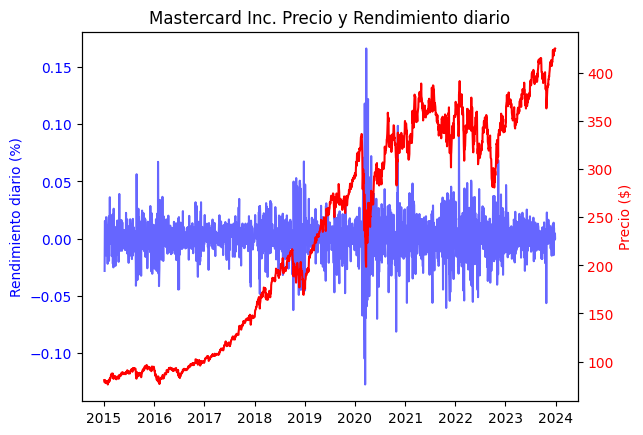

In [4]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
color = 'blue'
ax1.set_ylabel('Rendimiento diario (%)', color=color)
ax1.plot(tickerDf['Daily Return'], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()

color = 'red'
ax2.set_xlabel('Date')
ax2.set_ylabel('Precio ($)', color=color)
ax2.plot(tickerDf['Close'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Mastercard Inc. Precio y Rendimiento diario')

plt.show()

In [5]:
rendimientos = tickerDf['Daily Return'].dropna()
rendimientos.head()

Date
2015-01-05 00:00:00-05:00   -0.028128
2015-01-06 00:00:00-05:00   -0.002161
2015-01-07 00:00:00-05:00    0.015555
2015-01-08 00:00:00-05:00    0.015554
2015-01-09 00:00:00-05:00   -0.012744
Name: Daily Return, dtype: float64

In [6]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(rendimientos)

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

# Interpretar los resultados
if result[1] <= 0.05:
    print('La serie parece ser estacionaria (rechazamos la hipótesis nula de no estacionariedad).')
else:
    print('La serie parece no ser estacionaria (no podemos rechazar la hipótesis nula de no estacionariedad).')

ADF Statistic: -12.91858432594529
p-value: 3.918111148595979e-24
Critical Values:
	1%: -3.4332635674843694
	5%: -2.8628271349445633
	10%: -2.5674552025417263
La serie parece ser estacionaria (rechazamos la hipótesis nula de no estacionariedad).


In [7]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import warnings
best_aic = float("inf")
best_order = None
best_model = None
warnings.filterwarnings("ignore")
for p in range(5):  # prueba valores de p de 0 a 2
    for d in range(2):  # prueba valores de d de 0 a 1
        for q in range(5):  # prueba valores de q de 0 a 2
            try:
                model = ARIMA(rendimientos, order=(p, d, q))
                results = model.fit()
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_order = (p, d, q)
                    best_model = results
            except:
                continue

print(f"Mejor modelo ARIMA: ARIMA{best_order} - AIC: {best_aic}")
print(best_model.summary())
bestarima = best_model


Mejor modelo ARIMA: ARIMA(4, 1, 3) - AIC: -11943.432473803125
                               SARIMAX Results                                
Dep. Variable:           Daily Return   No. Observations:                 2263
Model:                 ARIMA(4, 1, 3)   Log Likelihood                5979.716
Date:                Mon, 24 Jun 2024   AIC                         -11943.432
Time:                        12:38:55   BIC                         -11897.640
Sample:                             0   HQIC                        -11926.723
                               - 2263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7217      0.059    -29.312      0.000      -1.837      -1.607
ar.L2         -0.9036      0.065    -13.850      0.000      -1.032   

# Mejor modelo ARIMA: ARIMA(4, 1, 3)

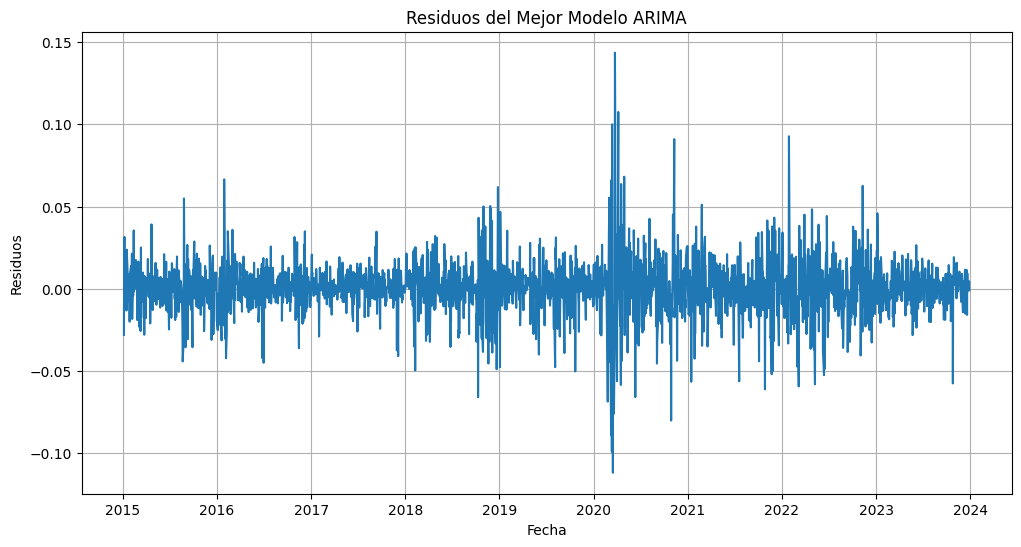

In [9]:
# Diagnóstico de residuos del mejor modelo
residuals = best_model.resid
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(residuals)
plt.title('Residuos del Mejor Modelo ARIMA')
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.grid(True)
plt.show()


In [98]:
from statsmodels.stats.diagnostic import het_arch

lb_test = het_arch(residuals)
print("Estadístico de prueba Ljung-Box:", lb_test[0])
print("Valor p:", lb_test[1])

Estadístico de prueba Ljung-Box: 561.0142584347119
Valor p: 3.936235132750433e-114


# ARCH(1)

In [87]:
arch_model = arch_model(residuals, vol='ARCH', p=1)
arch_fit = arch_model.fit()
print(arch_fit.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 3394113998.238612
Iteration:      2,   Func. Count:     16,   Neg. LLF: 2285520145.3549533
Iteration:      3,   Func. Count:     27,   Neg. LLF: 627853145.0827334
Iteration:      4,   Func. Count:     37,   Neg. LLF: -6112.150416681161
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6112.1504163680875
            Iterations: 8
            Function evaluations: 37
            Gradient evaluations: 4
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                6112.15
Distribution:                  Normal   AIC:                          -12218.3
Method:            Maximum Likelihood   BIC:                          -12201.1
                           

# Encontrar ARCH/GARCH. Elige GARCH(1,1)

In [104]:
from arch import arch_model

model = arch_model(residuals)
results = model.fit()

print(results.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4907559031.719381
Iteration:      2,   Func. Count:     18,   Neg. LLF: -6334.371783691369
Optimization terminated successfully    (Exit mode 0)
            Current function value: -6334.371787268534
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6334.37
Distribution:                  Normal   AIC:                          -12660.7
Method:            Maximum Likelihood   BIC:                          -12637.8
                                        No. Observations:                 2263
Date:                Mon, Jun 24 2024   Df Residuals:                     2262
Time:          

In [103]:
from arch import arch_model

ps = range(0, 3)  # p = 0, 1, 2
qs = range(0, 3)  # q = 0, 1, 2
best_model = None
best_aic = float('inf')
for t in ['ARCH', 'GARCH']:
  for p in ps:
      for q in qs:
        try:
            model = arch_model(residuals, vol=t, p=p, q=q)
            model_fit = model.fit(disp='off')
            current_aic = model_fit.aic

            if current_aic < best_aic:
                best_aic = current_aic
                best_model = model_fit
                best_p = p
                best_q = q

        except:
            continue
print("Mejor modelo GARCH({},{}) encontrado:".format(best_p, best_q))
print(best_model.summary())

Mejor modelo GARCH(1,1) encontrado:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                6334.37
Distribution:                  Normal   AIC:                          -12660.7
Method:            Maximum Likelihood   BIC:                          -12637.8
                                        No. Observations:                 2263
Date:                Mon, Jun 24 2024   Df Residuals:                     2262
Time:                        12:06:17   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         4.2896e-04 

In [14]:
import pandas as pd
residuals_df = pd.DataFrame(residuals, columns=['Residuals'])
residuals_df.to_csv('residuals.csv', index=False)

# En R

In [3]:
install.packages("rugarch")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [4]:
library(rugarch)

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




In [5]:
spec <- ugarchspec(
  variance.model = list(model = "sGARCH", garchOrder = c(1, 1)),
  mean.model = list(armaOrder = c(4, 3), include.mean = TRUE),
  distribution.model = "norm"
)

In [13]:
data <- read.csv("/content/residuals.csv")
data_vector <- as.numeric(data$Residuals)

In [14]:
fit <- ugarchfit(spec = spec, data = data)

# Resumen del ajuste
summary(fit)

Warning message in arima(data, order = c(modelinc[2], 0, modelinc[3]), include.mean = modelinc[1], :
“possible convergence problem: optim gave code = 1”


   Length     Class      Mode 
        1 uGARCHfit        S4 

In [18]:
coeficientes <- coef(fit)
print(coeficientes)

           mu           ar1           ar2           ar3           ar4 
 4.748857e-04  1.373044e+00 -1.328788e+00  8.740452e-01 -3.301331e-03 
          ma1           ma2           ma3         omega        alpha1 
-1.390854e+00  1.349818e+00 -9.123134e-01  9.049056e-06  1.471815e-01 
        beta1 
 8.255577e-01 



please wait...calculating quantiles...


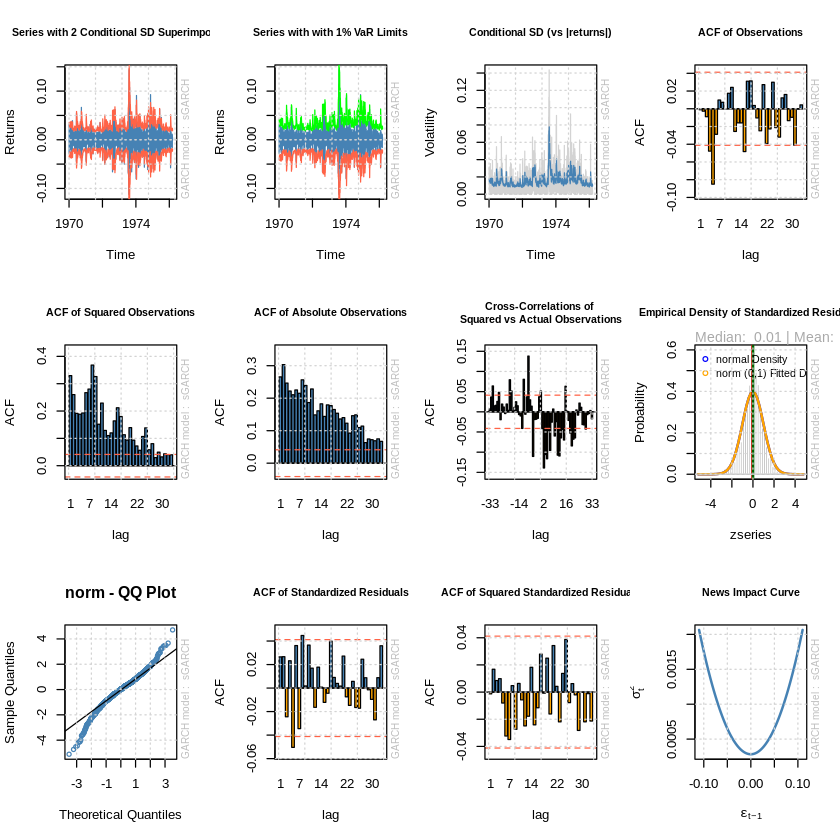

In [19]:
# Diagnóstico de residuos
plot(fit, which = "all")

### ARIMA(4,1,3)

$$
\Delta Y_t = \mu + \phi_1 \Delta Y_{t-1} + \phi_2 \Delta Y_{t-2} + \phi_3 \Delta Y_{t-3} + \phi_4 \Delta Y_{t-4} + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \theta_3 \epsilon_{t-3} + \epsilon_t
$$

$$
\Delta Y_t = 4.748857 \times 10^{-4} + 1.373044 \Delta Y_{t-1} - 1.328788 \Delta Y_{t-2} + 0.874045 \Delta Y_{t-3} - 0.003301 \Delta Y_{t-4} - 1.390854 \epsilon_{t-1} + 1.349818 \epsilon_{t-2} - 0.912313 \epsilon_{t-3} + \epsilon_t
$$


### Fórmula de la Varianza GARCH(1,1)

$$
\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2
$$


$$
\sigma_t^2 = 9.049056 \times 10^{-6} + 0.147181 \epsilon_{t-1}^2 + 0.825558 \sigma_{t-1}^2
$$


**Ahora simularemos más ejemplos en Stata**